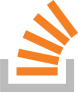

# Catégorisez automatiquement des questions - Méthode supervisée

### Sommaire


* [1. Importation des librairies, définition des fonctions et importation du fichier](#1)
    * [1.1 Importation des librairies](#1_1)
    * [1.2 Fonctions](#1_2)
    * [1.3 Importation du fichier](#1_3)
* [2. Prétraitements des données](#2)
    * [2.1 Matrices X et y](#2_1)
    * [2.2 Vectorizer](#2_2)
    * [2.3 Word2Vec](#2_3)
        * [2.3.1 Création du modèle Word2Vec](#2_3_1)
        * [2.3.2 Création de la matrice d'embedding](#2_3_2)
        * [2.3.3 Création du modèle d'embedding](#2_3_3)
        * [2.3.4 Exécution du modèle](#2_3_4)
    * [2.4 BERT](#2_4)
        * [2.4.1 Fonctions communes](#2_4_1)
        * [2.4.2 BERT HuggingFace](#2_4_2)
        * [2.4.3 BERT hub Tensorflow](#2_4_3)
    * [2.5 USE - Universal Sentence Encoder](#2_5)
* [3. Lien MLFlow](#3)
* [4. Mise en place des modèles avec TfIdf](#4)
    * [4.1 Régression Logistique](#4_1)
    * [4.2 Random Forest](#4_2)
    * [4.3 XGBoost](#4_3)
* [5. Mise en place des modèles avec Word2Vec](#5)
    * [5.1 Régression Logistique](#5_1)
    * [5.2 Random Forest](#5_2)
    * [5.3 XGBoost](#5_3)
* [6. Mise en place des modèles avec BERT](#6)
    * [6.1 Régression Logistique](#6_1)
    * [6.2 Random Forest](#6_2)
    * [6.3 XGBoost](#6_3)
* [7. Mise en place des modèles avec USE](#7)
    * [7.1 Régression Logistique](#7_1)
    * [7.2 Random Forest](#7_2)
    * [7.3 XGBoost](#7_3)
* [8. Choix du modèle](#8)
    * [8.1 Comparaison des scores](#8_1)
    * [8.2 Comparaison des pourcentages de prédictions](#8_2)
    * [8.3 Comparaison du temps d'exécution](#8_3)
* [9. Model Registry](#9)
    * [9.1 Interraction avec le serveur MLflow Tracking pour extraire le run id avec les meilleur performances](#9_1)
    * [9.2 Interraction avec le Model Registry](#9_2)
* [10. Prédictions des modèles sur la base entière](#10)
* [11. Enregistrement des .pkl pour l'API](#11)

## 1. Importation des librairies, définition des fonctions et importation du fichier <a class="anchor" id="1"></a>

### 1.1 Importation des librairies <a class="anchor" id="1_1"></a>

In [1]:
# Data
import pandas as pd
import numpy as np

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#Time
import time

# mlflow
import os
import mlflow

# Sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score, accuracy_score, f1_score, recall_score, precision_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import manifold, decomposition, cluster, metrics

# XGBoost
from xgboost import XGBClassifier

# Tensorflow
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

# Gensim
import gensim

# Multiprocessing
import multiprocessing

# Pour les messages
import logging
logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

# Enregistrement
import pickle

C:\Users\Basti\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\Basti\anaconda3\Lib\site-packages\transformers\generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
C:\Users\Basti\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
C:\Users\Basti\anaconda3\Lib\site-packages\transformers\generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and

### 1.2 Fonctions <a class="anchor" id="1_2"></a>

In [2]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des questions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des questions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

def grid(model, params):
    """Créer une GridSearchCV qui prendra le model 
    et les paramètres à optimiser en entrée"""
    grid = GridSearchCV(model,
                        params,
                        cv=5,
                        scoring='jaccard_micro',
                        n_jobs=-1)
    return grid
    
def best_params (model, params, grid_name, X_train, y_train):
    """Fonction pour calculer les meilleurs paramètres du modèle"""
    grid_name = grid(OneVsRestClassifier(model), params)
    grid_name.fit(X_train, y_train)
    best_params = grid_name.best_params_
    
    return best_params

def mlflow_run (run_name, model, X_train, y_train, X_test, y_test, best_params, model_name):
    """Fonction qui lance la run MLFlow et qui l'enregistre"""
    with mlflow.start_run(run_name = run_name) as run:
        # Entraîner le modèle
        model.fit(X_train, y_train)
        
        # Enregistrement du temps actuel
        start_time = time.time()
        
        # Prédictions
        y_pred = model.predict(X_test)
        
        # Enregistrement du temps d'éxécution du modèle
        execution_time = time.time() - start_time
        
        # Calculer les scores du modèle sur le test set
        jaccard_index = jaccard_score(y_test, y_pred, average='micro')
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='micro')
        recall = recall_score(y_test, y_pred, average='micro')
        precision = precision_score(y_test, y_pred, average='micro')
        
        # Enregistrer les résultats dans MLFlow
        mlflow.log_params(best_params)
        mlflow.log_metric("jaccard_score", jaccard_index)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("f1_score", f1)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("precision", precision)
        mlflow.sklearn.log_model(model, model_name)
        
    return { 
        'lien': mlflow.get_artifact_uri(), 
        'jaccard_index': jaccard_index, 
        'accuracy': accuracy, 
        'f1': f1, 
        'recall': recall, 
        'precision': precision,
        'y_pred': y_pred,
        'execution_time': execution_time
    }
            
# Créer un DataFrame vide pour stocker les résultats des modèles
df_results = pd.DataFrame(columns=['Model', 'Accuracy', 'F1_score', 'Jaccard_score', 'Precision', 
                                   'recall', 'Taux de prédiction sur Test_set', "Temps d'exécution du modèle"])
    
def score(df_results, model_name, jaccard_index, accuracy, f1, recall, precision, temps_execution, y_pred):
    """Fonction pour calculer le taux de prédiction du modèle sur le test set
    et ajouter les scores dans un DataFrame"""
    # Création de predicted_tags pour stocker les prédiction du modèle sur le test set
    predicted_tags = multilabel_binarizer.inverse_transform(y_pred)
    
    # Calcul du nombre de questions avec prédiction vide
    nb_sans_prediction = sum(all(tag == '()' for tag in tags) for tags in predicted_tags)

    # Affichage du taux de prédiction (Nombre de questions avec prédiction)
    taux = ((len(predicted_tags) - nb_sans_prediction) / len(predicted_tags)) * 100
    
    # Ajouter les résultats du modèle au DataFrame global en supprimant les potentiels doublons
    df_results.loc[df_results.shape[0]] = [model_name, accuracy, f1, jaccard_index, precision, recall, taux, temps_execution]
    df_results = df_results.drop_duplicates(subset=['Model'])

    return df_results

### 1.3 Importation du fichier <a class="anchor" id="1_3"></a>

In [3]:
# Charger les données
df = pd.read_csv('questions_cleaned.csv')
df.head()

,Id,clean_title_body,clean_tags
0,45026159,"['data', 'binding', 'adapter', 'android', 'pop...",['android']
1,45036635,"['thread', 'starvation', 'performance', 'testi...","['.net', 'c#']"
2,45037328,"['http', 'proxy', 'completely', 'ssl', 'connec...",['python']
3,45037335,"['chart', 'chart', 'color', 'border', 'line', ...","['javascript', 'react']"
4,45037547,"['logarithm', 'rust', 'java', 'rust', 'per', '...",['java']


In [4]:
# Déterminons la liste des catégories
l_cat = list(set(df['clean_tags'].values))

In [5]:
# Détrerminons l'indice numérique des catégories
y_cat_num = [(1-l_cat.index(df.iloc[i]['clean_tags'])) for i in range(len(df))]

## 2. Prétraitements des données <a class="anchor" id="2"></a>

### 2.1 Matrices X et y <a class="anchor" id="2_1"></a>

In [6]:
# On instancie X et y
X = df['clean_title_body'].values
y = df['clean_tags'].values

In [7]:
# Convertir la colonne 'clean_tags' en une liste de listes
y = df['clean_tags'].apply(lambda x: eval(x))

# Encodage du vecteur des étiquettes de données
multilabel_binarizer = MultiLabelBinarizer()
y = multilabel_binarizer.fit_transform(y)
y

array([[0, 0, 1, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [8]:
y.shape

(40401, 20)

### 2.2 Vectorizer <a class="anchor" id="2_2"></a>

In [9]:
# Vectorialisation
# Création d'une matrice document-token CountVectorizer
count_vectorizer = CountVectorizer(analyzer='word',
                                   max_df = 0.7,
                                   min_df = 0.05,
                                   stop_words='english')

X_cv = count_vectorizer.fit_transform(X).toarray()

# Création d'une matrice document-token TF-IDF
tfidf_vectorizer = TfidfVectorizer(analyzer='word',
                                   max_df = 0.7,
                                   min_df = 0.05,
                                   stop_words='english')

X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

In [10]:
print("CountVectorizer : ")
print("-----------------")
ARI, X_tsne, labels = ARI_fct(X_cv)
print()
print("Tf-idf : ")
print("--------")
ARI, X_tsne, labels = ARI_fct(X_tfidf)

CountVectorizer : 
-----------------
ARI :  0.0139 time :  235.0

Tf-idf : 
--------
ARI :  0.0144 time :  232.0


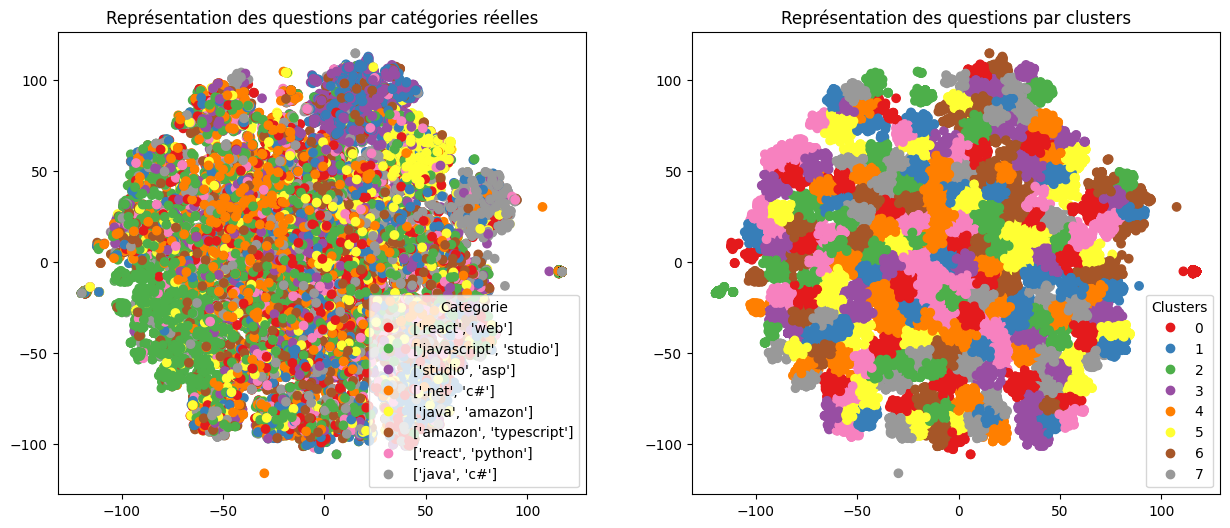

ARI :  0.0144


In [11]:
 TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 2.3 Word2Vec <a class="anchor" id="2_2"></a>

#### 2.3.1 Création du modèle Word2Vec <a class="anchor" id="2_3_1"></a>

In [12]:
w2v_size=100
w2v_window=5
w2v_min_count=1
w2v_epochs=30
maxlen = 24
sentences = df['clean_title_body'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [13]:
# Création et entraînement du modèle Word2Vec
print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, 
                                   window=w2v_window,
                                   vector_size=w2v_size,
                                   seed=42,
                                   workers=multiprocessing.cpu_count())

w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 9949
Word2Vec trained


In [14]:
# Préparation des sentences (tokenization)
print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                            maxlen=maxlen,
                            padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 9950


#### 2.3.2 Création de la matrice d'embedding <a class="anchor" id="2_3_2"></a>

In [15]:
# Création de la matrice d'embedding
print("Create Embedding matrix ...")
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (9950, 100)


#### 2.3.3 Création du modèle d'embedding <a class="anchor" id="2_3_3"></a>

In [16]:
# Création du modèle
input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 24)]              0         
                                                                 
 embedding (Embedding)       (None, 24, 100)           995000    
                                                                 
 global_average_pooling1d (  (None, 100)               0         
 GlobalAveragePooling1D)                                         
                                                                 
Total params: 995000 (3.80 MB)
Trainable params: 995000 (3.80 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### 2.3.4 Exécution du modèle <a class="anchor" id="2_3_4"></a>

In [17]:
# Exécutuion du modèle
embeddings = embed_model.predict(x_sentences)
embeddings.shape

1263/1263 [==============================] - 1s 529us/step


(40401, 100)

In [18]:
ARI, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.0228 time :  234.0


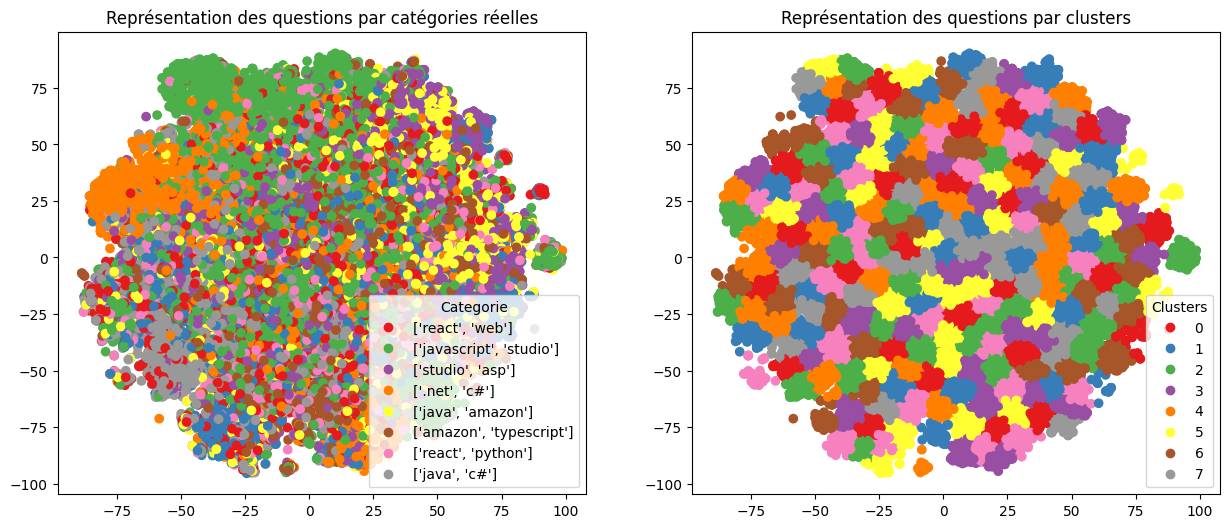

ARI :  0.0228


In [19]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 2.4 BERT <a class="anchor" id="2_4"></a>

In [20]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.15.0
2.15.0
Num GPUs Available:  0
False


#### 2.4.1 Fonctions communes <a class="anchor" id="2_4_1"></a>

In [21]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

#### 2.4.2 BERT HuggingFace <a class="anchor" id="2_4_2"></a>

In [22]:
max_length = 32
batch_size = 201
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type, from_pt=True)
sentences = df['clean_title_body'].to_list()

In [23]:
# Création des features
features_bert_hugging, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  529.0


In [24]:
ARI, X_tsne, labels = ARI_fct(features_bert_hugging)

ARI :  0.0161 time :  237.0


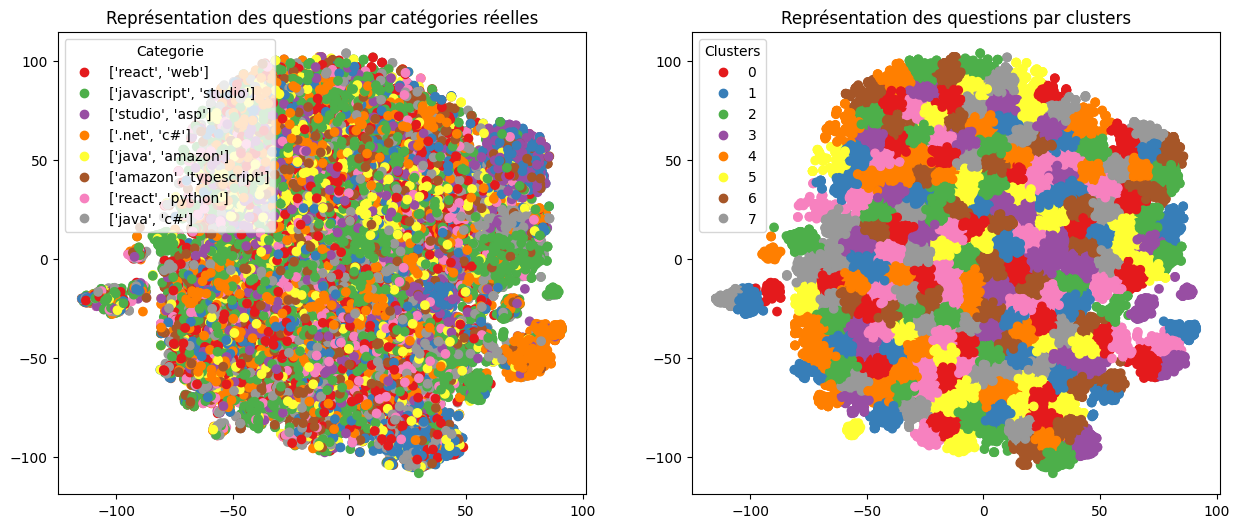

ARI :  0.0161


In [25]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

#### 2.4.3 BERT hub Tensorflow <a class="anchor" id="2_4_3"></a>

In [26]:
# On va maintenant utiliser TensorFlow Hub pour récupérer un modèle préentraîné
model_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
bert_layer = hub.KerasLayer(model_url, trainable=True)
sentences = df['clean_title_body'].to_list()

In [27]:
max_length = 32
batch_size = 201
model_type = 'bert-base-uncased'
model = bert_layer

features_bert_hub, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  575.0


In [28]:
ARI, X_tsne, labels = ARI_fct(features_bert_hub)

ARI :  0.0154 time :  239.0


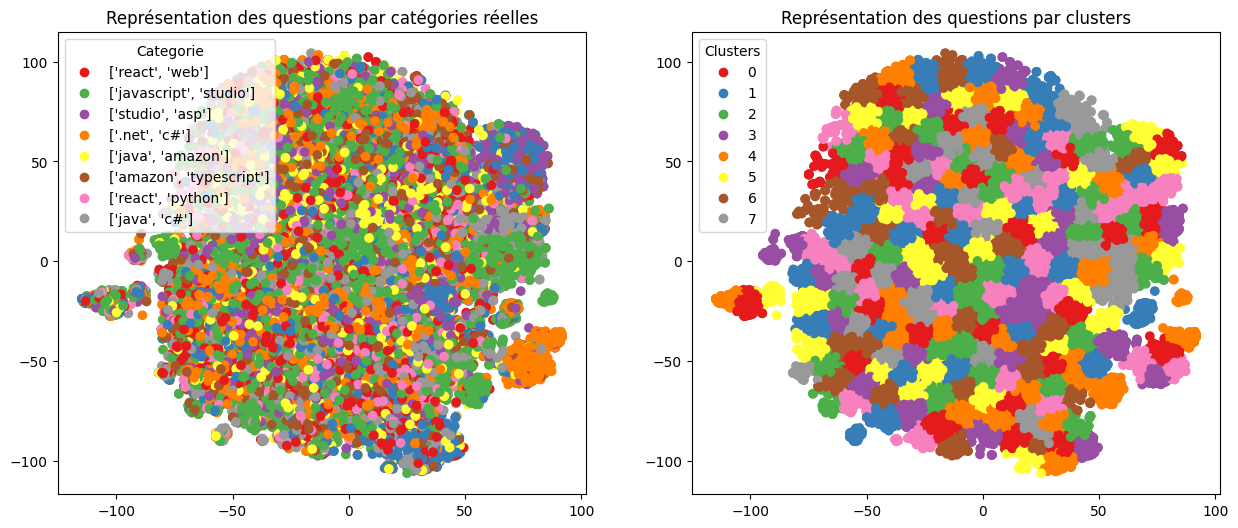

ARI :  0.0154


In [29]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

### 2.5 USE - Universal Sentence Encoder <a class="anchor" id="2_5"></a>

In [30]:
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [31]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [32]:
batch_size = 201
sentences = df['clean_title_body'].to_list()

In [33]:
features_USE = feature_USE_fct(sentences, batch_size)

In [34]:
ARI, X_tsne, labels = ARI_fct(features_USE)

ARI :  0.0351 time :  231.0


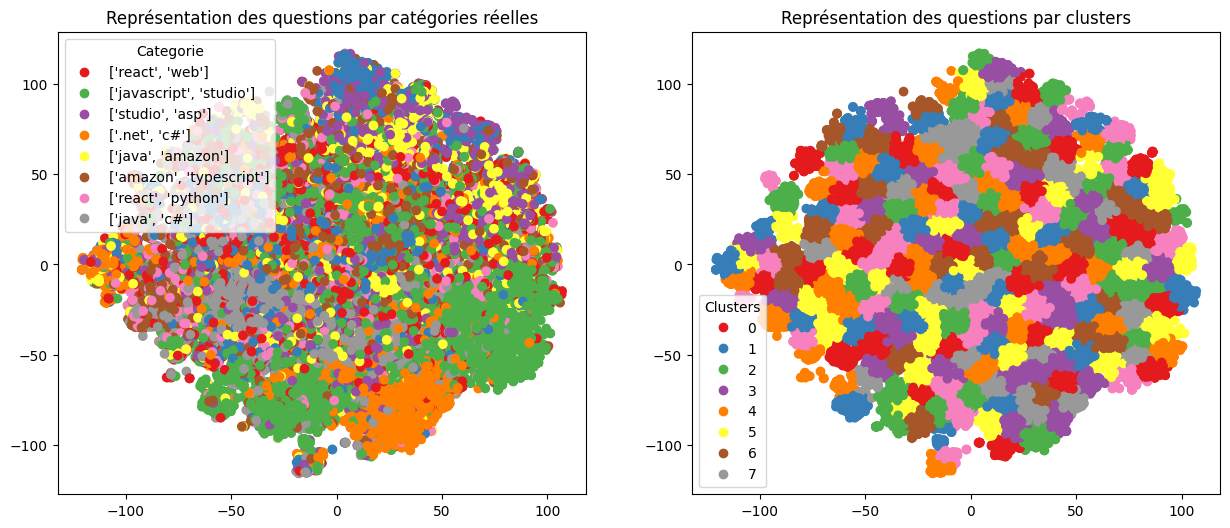

ARI :  0.0351


In [35]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI)

## 3. Lien MLFlow <a class="anchor" id="3"></a>

In [36]:
# Définir le chemin du répertoire de suivi
mlflow.set_tracking_uri("file:///" + os.path.expanduser('~/mlruns'))

In [37]:
# Identification du nom du projet MLflow
mlflow.set_experiment("Tags_predict")

<Experiment: artifact_location='file:///C:\\Users\\Basti/mlruns/416587785806061639', creation_time=1706916647078, experiment_id='416587785806061639', last_update_time=1706916647078, lifecycle_stage='active', name='Tags_predict', tags={}>

In [38]:
from pyngrok import ngrok
# Terminate open tunels if exist
ngrok.kill()

# Setting the authtoken
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = '2b23hnwzT4i2IwyrnERQYBHW6oM_5KfLu5ne9aeQKmtUtyZLK'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
# Utiliser la commande shell mlflow ui pour l'activer
ngrok_tunel = ngrok.connect(addr='5000', proto='http', bind_tls=True)
print('MLflow Tracking UI:', ngrok_tunel.public_url)

MLflow Tracking UI: https://8275-2a01-e0a-b69-82d0-1832-7d3d-9a03-e0db.ngrok-free.app


Exécuter 'mlflow ui' dans un terminal et cliquer ensuite sur le lien ci-dessus.

## 4. Mise en place des modèles avec TfIdf <a class="anchor" id="4"></a>

In [39]:
# Séparer en matrice de train et de test pour le Tf-Idf
X_train_tfidf, X_test_tfidf, y_train_tfidf, y_test_tfidf = train_test_split(X_tfidf, y, test_size=0.3, random_state=0)
print('X_train:', X_train_tfidf.shape)
print('X_test:', X_test_tfidf.shape)
print('y_train:', y_train_tfidf.shape)
print('y_test:', y_test_tfidf.shape)

X_train: (28280, 62)
X_test: (12121, 62)
y_train: (28280, 20)
y_test: (12121, 20)


### 4.1 Régression Logistique <a class="anchor" id="4_1"></a>

In [40]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__penalty': ['l2', None],
    'estimator__max_iter': [200, 1500, 3000]
}

# Choix du modèle
model = LogisticRegression()

# Enregistrement des meilleurs paramètres de la grille de recherche
TfIdf_reg_logistic_best_params = best_params (model, params, 'log_reg_grid ', X_train_tfidf, y_train_tfidf)
TfIdf_reg_logistic_best_params

{'estimator__max_iter': 200, 'estimator__penalty': None}

In [41]:
# Initialisation du modèle avec les meilleurs paramètres
log_reg = OneVsRestClassifier(LogisticRegression(penalty = TfIdf_reg_logistic_best_params['estimator__penalty'],
                                                 max_iter = TfIdf_reg_logistic_best_params['estimator__max_iter']))

log_reg

OneVsRestClassifier(estimator=LogisticRegression(max_iter=200, penalty=None))

In [42]:
# Enregistrement de la run dans MLFlow
scores_TfIdf_reg_log = mlflow_run('TfIdf_reg_logistic_best_params', log_reg, X_train_tfidf, y_train_tfidf, X_test_tfidf, 
            y_test_tfidf, TfIdf_reg_logistic_best_params, 'log_reg')

mlflow.end_run()

scores_TfIdf_reg_log['lien']

C:\Users\Basti\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


'file:///C:\\Users\\Basti/mlruns/416587785806061639/9015e019004d42679356e163d5fee708/artifacts'

In [43]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'TfIdf_reg_logistic', scores_TfIdf_reg_log['jaccard_index'], 
      scores_TfIdf_reg_log['accuracy'], scores_TfIdf_reg_log['f1'], scores_TfIdf_reg_log['recall'], 
      scores_TfIdf_reg_log['precision'], scores_TfIdf_reg_log['execution_time'], scores_TfIdf_reg_log['y_pred'])

df_results.loc[df_results['Model'] == 'TfIdf_reg_logistic']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
0,TfIdf_reg_logistic,0.176306,0.337424,0.202953,0.826463,0.211987,31.622803,0.010002


### 4.2 Random Forest <a class="anchor" id="4_2"></a>

In [44]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__max_depth': [8, 9, 10]
}

# Choix du modèle
model = RandomForestClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
TfIdf_random_forest_best_params = best_params (model, params, 'random_forest_grid ', X_train_tfidf, y_train_tfidf)
TfIdf_random_forest_best_params

{'estimator__max_depth': 10, 'estimator__n_estimators': 1000}

In [45]:
# Initialisation du modèle avec les meilleurs paramètres
random_forest = OneVsRestClassifier(
    RandomForestClassifier(n_estimators = TfIdf_random_forest_best_params['estimator__n_estimators'], 
                                                           max_depth = TfIdf_random_forest_best_params['estimator__max_depth'])
)

random_forest

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=1000))

In [46]:
# Enregistrement de la run dans MLFlow
scores_TfIdf_random_forest = mlflow_run('TfIdf_random_forest_best_params', random_forest, X_train_tfidf, 
                                        y_train_tfidf, X_test_tfidf, y_test_tfidf, 
                                        TfIdf_random_forest_best_params, 'random_forest')

mlflow.end_run()

scores_TfIdf_random_forest['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/aa855deb73df4a50812780625dc3e421/artifacts'

In [47]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'TfIdf_random_forest', scores_TfIdf_random_forest['jaccard_index'], scores_TfIdf_random_forest['accuracy'], 
      scores_TfIdf_random_forest['f1'], scores_TfIdf_random_forest['recall'], scores_TfIdf_random_forest['precision'], 
      scores_TfIdf_random_forest['execution_time'], scores_TfIdf_random_forest['y_pred'])

df_results.loc[df_results['Model'] == 'TfIdf_random_forest']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
1,TfIdf_random_forest,0.168633,0.327718,0.19597,0.873293,0.201706,29.585018,13.827183


### 4.3 XGBoost <a class="anchor" id="4_3"></a>

In [48]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [300, 500, 1000],
    'estimator__max_depth': [8, 9, 10],
    'estimator__learning_rate': [0.1, 0.2],
    'estimator__gamma': [0, 0.05, 0.1]
}

# Choix du modèle
model = XGBClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
TfIdf_xgboost_best_params = best_params (model, params, 'xgboost_grid ', X_train_tfidf, y_train_tfidf)
TfIdf_xgboost_best_params

{'estimator__gamma': 0.05,
 'estimator__learning_rate': 0.1,
 'estimator__max_depth': 10,
 'estimator__n_estimators': 300}

In [49]:
# Initialisation du modèle avec les meilleurs paramètres
xgboost = OneVsRestClassifier(XGBClassifier(n_estimators = TfIdf_xgboost_best_params['estimator__n_estimators'],
                                            max_depth = TfIdf_xgboost_best_params['estimator__max_depth'],
                                            learning_rate = TfIdf_xgboost_best_params['estimator__learning_rate'], 
                                            gamma = TfIdf_xgboost_best_params['estimator__gamma']))

xgboost

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0.05,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=10,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=300, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [50]:
# Enregistrement de la run dans MLFlow
scores_TfIdf_xgboost = mlflow_run('TfIdf_xgboost_best_params', xgboost, X_train_tfidf, 
                                        y_train_tfidf, X_test_tfidf, y_test_tfidf, 
                                        TfIdf_xgboost_best_params, 'xgboost')

mlflow.end_run()

scores_TfIdf_xgboost['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/56a038529889429c96b9398a04f987bf/artifacts'

In [51]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'TfIdf_xgboost', scores_TfIdf_xgboost['jaccard_index'], scores_TfIdf_xgboost['accuracy'], 
      scores_TfIdf_xgboost['f1'], scores_TfIdf_xgboost['recall'], scores_TfIdf_xgboost['precision'], 
      scores_TfIdf_xgboost['execution_time'], scores_TfIdf_xgboost['y_pred'])

df_results.loc[df_results['Model'] == 'TfIdf_xgboost']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
2,TfIdf_xgboost,0.199241,0.373922,0.229953,0.757171,0.248262,39.831697,0.339077


## 5. Mise en place des modèles avec Word2Vec <a class="anchor" id="5"></a>

In [52]:
X_w2v = embeddings
y_w2v = y

In [53]:
# Séparer en matrice de train et de test pour Word2Vec
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_w2v, test_size=0.3, random_state=0)
print('X_train:', X_train_w2v.shape)
print('X_test:', X_test_w2v.shape)
print('y_train:', y_train_w2v.shape)
print('y_test:', y_test_w2v.shape)

X_train: (28280, 100)
X_test: (12121, 100)
y_train: (28280, 20)
y_test: (12121, 20)


### 5.1 Régression Logistique <a class="anchor" id="5_1"></a>

In [54]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__penalty': ['l2', None],
    'estimator__max_iter': [200, 1500, 3000]
}

# Choix du modèle
model = LogisticRegression()

# Enregistrement des meilleurs paramètres de la grille de recherche
Word2Vec_reg_logistic_best_param = best_params (model, params, 'log_reg_grid ', X_train_w2v, y_train_w2v)
Word2Vec_reg_logistic_best_param

{'estimator__max_iter': 200, 'estimator__penalty': None}

In [55]:
# Initialisation du modèle avec les meilleurs paramètres
log_reg = OneVsRestClassifier(LogisticRegression(penalty = Word2Vec_reg_logistic_best_param['estimator__penalty'],
                                                 max_iter = Word2Vec_reg_logistic_best_param['estimator__max_iter']))

log_reg

OneVsRestClassifier(estimator=LogisticRegression(max_iter=200, penalty=None))

In [56]:
# Enregistrement de la run dans MLFlow
scores_Word2Vec_reg_logistic = mlflow_run('Word2Vec_reg_logistic_best_param', log_reg, X_train_w2v, 
                                          y_train_w2v, X_test_w2v, y_test_w2v, 
                                          Word2Vec_reg_logistic_best_param, 'log_reg')

mlflow.end_run()

scores_Word2Vec_reg_logistic['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/a65d6514b0a34fd993267d39ab13cb9c/artifacts'

In [57]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Word2Vec_reg_logistic', scores_Word2Vec_reg_logistic['jaccard_index'], 
      scores_Word2Vec_reg_logistic['accuracy'], scores_Word2Vec_reg_logistic['f1'], 
      scores_Word2Vec_reg_logistic['recall'], scores_Word2Vec_reg_logistic['precision'], 
      scores_Word2Vec_reg_logistic['execution_time'], scores_Word2Vec_reg_logistic['y_pred'])

df_results.loc[df_results['Model'] == 'Word2Vec_reg_logistic']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
3,Word2Vec_reg_logistic,0.31235,0.513969,0.345867,0.7452,0.392254,58.246019,0.04301


### 5.2 Random Forest <a class="anchor" id="5_2"></a>

In [58]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__max_depth': [8, 9, 10]
}

# Choix du modèle
model = RandomForestClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Word2Vec_random_forest_best_params = best_params (model, params, 'random_forest_grid ', X_train_w2v, y_train_w2v)
Word2Vec_random_forest_best_params

{'estimator__max_depth': 10, 'estimator__n_estimators': 200}

In [62]:
# Initialisation du modèle avec les meilleurs paramètres
random_forest = OneVsRestClassifier(
    RandomForestClassifier(n_estimators = Word2Vec_random_forest_best_params['estimator__n_estimators'],
                           max_depth = Word2Vec_random_forest_best_params['estimator__max_depth'])
)

random_forest

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=200))

In [63]:
# Enregistrement de la run dans MLFlow
scores_Word2Vec_random_forest = mlflow_run('Word2Vec_random_forest_best_params', random_forest, X_train_w2v, 
                                           y_train_w2v, X_test_w2v, y_test_w2v, 
                                           Word2Vec_random_forest_best_params, 'random_forest')

mlflow.end_run()

scores_Word2Vec_random_forest['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/2c8baa3ece074a5e9f991e713d4b9da1/artifacts'

In [64]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Word2Vec_random_forest', scores_Word2Vec_random_forest['jaccard_index'], 
      scores_Word2Vec_random_forest['accuracy'], scores_Word2Vec_random_forest['f1'], 
      scores_Word2Vec_random_forest['recall'], scores_Word2Vec_random_forest['precision'], 
      scores_Word2Vec_random_forest['execution_time'], scores_Word2Vec_random_forest['y_pred'])

df_results.loc[df_results['Model'] == 'Word2Vec_random_forest']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
4,Word2Vec_random_forest,0.170695,0.288124,0.168309,0.870911,0.172615,25.72395,3.407773


### 5.3 XGBoost <a class="anchor" id="5_3"></a>

In [65]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [300, 500, 1000],
    'estimator__max_depth': [8, 9, 10],
    'estimator__learning_rate': [0.1, 0.2],
    'estimator__gamma': [0, 0.05, 0.1]
}
# Choix du modèle
model = XGBClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Word2Vec_xgboost_best_params = best_params (model, params, 'xgboost_grid ', X_train_w2v, y_train_w2v)
Word2Vec_xgboost_best_params

ERROR:pyngrok.process.ngrok:t=2024-02-03T13:04:12+0100 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=0d9b901d6fc7 err="read tcp [2a01:e0a:b69:82d0:1832:7d3d:9a03:e0db]:50699->[2600:1f16:d83:1201::6e74:4]:443: wsarecv: Une connexion Ã©tablie a Ã©tÃ© abandonnÃ©e par un logiciel de votre ordinateur hÃ´te."
ERROR:pyngrok.process.ngrok:t=2024-02-03T13:04:21+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=c9bfce266e56 clientid=e290c914e600bf4df846d81b284f520a
ERROR:pyngrok.process.ngrok:t=2024-02-03T13:04:22+0100 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=0d9b901d6fc7 err="failed to dial ngrok server with address \"connect.us.ngrok-agent.com:443\": dial tcp: lookup connect.us.ngrok-agent.com: i/o timeout"
ERROR:pyngrok.process.ngrok:t=2024-02-03T13:04:32+0100 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=0d9b901d6fc7 err="failed to dial ngrok se

{'estimator__gamma': 0,
 'estimator__learning_rate': 0.2,
 'estimator__max_depth': 8,
 'estimator__n_estimators': 1000}

In [66]:
# Initialisation du modèle avec les meilleurs paramètres
xgboost = OneVsRestClassifier(XGBClassifier(n_estimators = Word2Vec_xgboost_best_params['estimator__n_estimators'],
                                                max_depth = Word2Vec_xgboost_best_params['estimator__max_depth'],
                                                learning_rate = Word2Vec_xgboost_best_params['estimator__learning_rate'], 
                                                gamma = Word2Vec_xgboost_best_params['estimator__gamma']))
    

xgboost

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [67]:
# Enregistrement de la run dans MLFlow
scores_Word2Vec_xgboost = mlflow_run('Word2Vec_xgboost_best_params', xgboost, X_train_w2v, 
                                     y_train_w2v, X_test_w2v, y_test_w2v, 
                                     Word2Vec_xgboost_best_params, 'xgboost')

mlflow.end_run()

scores_Word2Vec_xgboost['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/e0fb63335e644fcc9b2c654727540929/artifacts'

In [68]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Word2Vec_xgboost', scores_Word2Vec_xgboost['jaccard_index'], 
      scores_Word2Vec_xgboost['accuracy'], scores_Word2Vec_xgboost['f1'], 
      scores_Word2Vec_xgboost['recall'], scores_Word2Vec_xgboost['precision'], 
      scores_Word2Vec_xgboost['execution_time'], scores_Word2Vec_xgboost['y_pred'])

df_results.loc[df_results['Model'] == 'Word2Vec_xgboost']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
5,Word2Vec_xgboost,0.329016,0.524784,0.355733,0.782045,0.394883,59.656794,0.491269


## 6. Mise en place des modèles avec BERT <a class="anchor" id="6"></a>

In [69]:
X_bert = features_bert_hugging
y_bert = y

In [70]:
# Séparer en matrice de train et de test pour BERT
X_train_bert, X_test_bert, y_train_bert, y_test_bert = train_test_split(X_bert, y_bert, test_size=0.3, random_state=0)
print('X_train:', X_train_bert.shape)
print('X_test:', X_test_bert.shape)
print('y_train:', y_train_bert.shape)
print('y_test:', y_test_bert.shape)

X_train: (28280, 768)
X_test: (12121, 768)
y_train: (28280, 20)
y_test: (12121, 20)


### 6.1 Régression Logistique <a class="anchor" id="6_1"></a>

In [71]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__penalty': ['l2', None],
    'estimator__max_iter': [200, 1500, 3000]
}

# Choix du modèle
model = LogisticRegression()

# Enregistrement des meilleurs paramètres de la grille de recherche
Bert_reg_logistic_best_param = best_params (model, params, 'log_reg_grid ', X_train_bert, y_train_bert)
Bert_reg_logistic_best_param

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'estimator__max_iter': 200, 'estimator__penalty': None}

In [72]:
# Initialisation du modèle avec les meilleurs paramètres
log_reg = OneVsRestClassifier(LogisticRegression(penalty = Bert_reg_logistic_best_param['estimator__penalty'],
                                                 max_iter = Bert_reg_logistic_best_param['estimator__max_iter']))
    

log_reg

OneVsRestClassifier(estimator=LogisticRegression(max_iter=200, penalty=None))

In [73]:
# Enregistrement de la run dans MLFlow
scores_Bert_reg_logistic = mlflow_run('Bert_reg_logistic_best_param', log_reg, X_train_bert, 
                                     y_train_bert, X_test_bert, y_test_bert, 
                                     Bert_reg_logistic_best_param, 'log_reg')

mlflow.end_run()

scores_Bert_reg_logistic['lien']

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

'file:///C:\\Users\\Basti/mlruns/416587785806061639/e70e58673d614e3c84099dfb8525c784/artifacts'

In [74]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Bert_reg_logistic', scores_Bert_reg_logistic['jaccard_index'], 
      scores_Bert_reg_logistic['accuracy'], scores_Bert_reg_logistic['f1'], 
      scores_Bert_reg_logistic['recall'], scores_Bert_reg_logistic['precision'], 
      scores_Bert_reg_logistic['execution_time'], scores_Bert_reg_logistic['y_pred'])

df_results.loc[df_results['Model'] == 'Bert_reg_logistic']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
6,Bert_reg_logistic,0.310535,0.522094,0.353266,0.739717,0.403411,61.744081,0.416435


### 6.2 Random Forest <a class="anchor" id="6_2"></a>

In [75]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__max_depth': [8, 9, 10]
}

# Choix du modèle
model = RandomForestClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Bert_random_forest_best_params = best_params (model, params, 'random_forest_grid ', X_train_bert, y_train_bert)
Bert_random_forest_best_params

ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:06+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=3ceb0dfcb3c0 clientid=e290c914e600bf4df846d81b284f520a
ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:06+0100 lvl=eror msg="session closed, starting reconnect loop" obj=tunnels.session obj=csess id=0d9b901d6fc7 err="session closed"
ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:31+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=93fa825c1ef6
ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:31+0100 lvl=eror msg="failed to reconnect session" obj=tunnels.session obj=csess id=0d9b901d6fc7 err="failed to send authentication request: session closed"
ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:57+0100 lvl=eror msg="heartbeat timeout, terminating session" obj=tunnels.session obj=csess id=bddff7c9c20b clientid=e290c914e600bf4df846d81b284f520a
ERROR:pyngrok.process.ngrok:t=2024-02-04T00:37:57+0100 lvl=eror msg="s

{'estimator__max_depth': 10, 'estimator__n_estimators': 200}

In [76]:
# Initialisation du modèle avec les meilleurs paramètres
random_forest = OneVsRestClassifier(RandomForestClassifier(n_estimators = Bert_random_forest_best_params['estimator__n_estimators'], 
                                                           max_depth = Bert_random_forest_best_params['estimator__max_depth']))
    

random_forest

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=200))

In [77]:
# Enregistrement de la run dans MLFlow
scores_Bert_random_forest = mlflow_run('Bert_random_forest_best_params', random_forest, X_train_bert, 
                                       y_train_bert, X_test_bert, y_test_bert, 
                                       Bert_random_forest_best_params, 'random_forest')

mlflow.end_run()

scores_Bert_random_forest['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/6571e3fd9ad1476fa3d18c964e80f148/artifacts'

In [78]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Bert_random_forest', scores_Bert_random_forest['jaccard_index'], 
      scores_Bert_random_forest['accuracy'], scores_Bert_random_forest['f1'], 
      scores_Bert_random_forest['recall'], scores_Bert_random_forest['precision'], 
      scores_Bert_random_forest['execution_time'], scores_Bert_random_forest['y_pred'])

df_results.loc[df_results['Model'] == 'Bert_random_forest']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
7,Bert_random_forest,0.080521,0.165445,0.090182,0.914269,0.090952,12.853725,6.873188


### 6.3 XGBoost <a class="anchor" id="6_3"></a>

In [79]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [300, 500, 1000],
    'estimator__max_depth': [8, 9, 10],
    'estimator__learning_rate': [0.1, 0.2],
    'estimator__gamma': [0, 0.05, 0.1]
}

# Choix du modèle
model = XGBClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Bert_xgboost_best_params = best_params (model, params, 'xgboost_grid ', X_train_bert, y_train_bert)
Bert_xgboost_best_params

{'estimator__gamma': 0,
 'estimator__learning_rate': 0.2,
 'estimator__max_depth': 8,
 'estimator__n_estimators': 1000}

In [80]:
# Initialisation du modèle avec les meilleurs paramètres
xgboost = OneVsRestClassifier(XGBClassifier(n_estimators = Bert_xgboost_best_params['estimator__n_estimators'],
                                            max_depth = Bert_xgboost_best_params['estimator__max_depth'],
                                            learning_rate = Bert_xgboost_best_params['estimator__learning_rate'], 
                                            gamma = Bert_xgboost_best_params['estimator__gamma']))
    

xgboost

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [81]:
# Enregistrement de la run dans MLFlow
scores_Bert_xgboost = mlflow_run('Bert_xgboost_best_params', xgboost, X_train_bert, 
                                       y_train_bert, X_test_bert, y_test_bert, 
                                       Bert_xgboost_best_params, 'xgboost')

mlflow.end_run()

scores_Bert_xgboost['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/e1abcbdaa5e841b382361858917d6497/artifacts'

In [82]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Bert_xgboost', scores_Bert_xgboost['jaccard_index'], 
      scores_Bert_xgboost['accuracy'], scores_Bert_xgboost['f1'], 
      scores_Bert_xgboost['recall'], scores_Bert_xgboost['precision'], 
      scores_Bert_xgboost['execution_time'], scores_Bert_xgboost['y_pred'])

df_results.loc[df_results['Model'] == 'Bert_xgboost']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
8,Bert_xgboost_best,0.242802,0.431754,0.27531,0.850859,0.289269,42.240739,0.907127


## 7. Mise en place des modèles avec USE <a class="anchor" id="7"></a>

In [83]:
X_use = features_USE
y_use = y

In [84]:
# Séparer en matrice de train et de test pour USE
X_train_use, X_test_use, y_train_use, y_test_use = train_test_split(X_use, y_use, test_size=0.3, random_state=0)
print('X_train:', X_train_use.shape)
print('X_test:', X_test_use.shape)
print('y_train:', y_train_use.shape)
print('y_test:', y_test_use.shape)

X_train: (28280, 512)
X_test: (12121, 512)
y_train: (28280, 20)
y_test: (12121, 20)


### 7.1 Régression Logistique <a class="anchor" id="7_1"></a>

In [85]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__penalty': ['l2', None],
    'estimator__max_iter': [10, 20 , 50 , 200, 3000]
}

# Choix du modèle
model = LogisticRegression()

# Enregistrement des meilleurs paramètres de la grille de recherche
Use_reg_logistic_best_param = best_params (model, params, 'log_reg_grid ', X_train_use, y_train_use)
Use_reg_logistic_best_param

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'estimator__max_iter': 50, 'estimator__penalty': None}

In [86]:
# Initialisation du modèle avec les meilleurs paramètres
log_reg = OneVsRestClassifier(LogisticRegression(penalty = Use_reg_logistic_best_param['estimator__penalty'],
                                                 max_iter = Use_reg_logistic_best_param['estimator__max_iter']))
    

log_reg

OneVsRestClassifier(estimator=LogisticRegression(max_iter=50, penalty=None))

In [87]:
# Enregistrement de la run dans MLFlow
scores_Use_reg_logistic = mlflow_run('Use_reg_logistic_best_param', log_reg, X_train_use, 
                                       y_train_use, X_test_use, y_test_use, 
                                       Use_reg_logistic_best_param, 'log_reg')

mlflow.end_run()

scores_Use_reg_logistic['lien']

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Basti\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

'file:///C:\\Users\\Basti/mlruns/416587785806061639/1727bde0388c4c529992c177a7d34514/artifacts'

In [88]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Use_reg_logistic', scores_Use_reg_logistic['jaccard_index'], 
      scores_Use_reg_logistic['accuracy'], scores_Use_reg_logistic['f1'], 
      scores_Use_reg_logistic['recall'], scores_Use_reg_logistic['precision'], 
      scores_Use_reg_logistic['execution_time'], scores_Use_reg_logistic['y_pred'])

df_results.loc[df_results['Model'] == 'Use_reg_logistic']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
9,Use_reg_logistic,0.410857,0.622158,0.451545,0.756567,0.528302,76.115832,0.254057


### 7.2 Random Forest <a class="anchor" id="7_2"></a>

In [89]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [200, 500, 1000],
    'estimator__max_depth': [8, 9, 10]
}

# Choix du modèle
model = RandomForestClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Use_random_forest_best_params = best_params (model, params, 'random_forest_grid ', X_train_use, y_train_use)
Use_random_forest_best_params

{'estimator__max_depth': 10, 'estimator__n_estimators': 500}

In [91]:
# Initialisation du modèle avec les meilleurs paramètres
random_forest = OneVsRestClassifier(RandomForestClassifier(
    n_estimators = Use_random_forest_best_params['estimator__n_estimators'], 
    max_depth = Use_random_forest_best_params['estimator__max_depth']))

random_forest

OneVsRestClassifier(estimator=RandomForestClassifier(max_depth=10,
                                                     n_estimators=500))

In [92]:
# Enregistrement de la run dans MLFlow
scores_Use_random_forest = mlflow_run('Use_random_forest_best_params', random_forest, X_train_use, 
                                       y_train_use, X_test_use, y_test_use, 
                                       Use_random_forest_best_params, 'random_forest')

mlflow.end_run()

scores_Use_random_forest['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/da520fff6e5b4f72b17f17aca08cfa95/artifacts'

In [93]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Use_random_forest', scores_Use_random_forest['jaccard_index'], 
      scores_Use_random_forest['accuracy'], scores_Use_random_forest['f1'], 
      scores_Use_random_forest['recall'], scores_Use_random_forest['precision'], 
      scores_Use_random_forest['execution_time'], scores_Use_random_forest['y_pred'])

df_results.loc[df_results['Model'] == 'Use_random_forest']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
10,Use_random_forest,0.257405,0.431868,0.275403,0.903796,0.28372,41.242472,11.522658


### 7.3 XGBoost <a class="anchor" id="7_3"></a>

In [94]:
# Créer un dictionnaire de paramètres pour la GridSearchCV
params = {
    'estimator__n_estimators': [300, 500, 1000],
    'estimator__max_depth': [8, 9, 10],
    'estimator__learning_rate': [0.1, 0.2],
    'estimator__gamma': [0, 0.05, 0.1]
}

# Choix du modèle
model = XGBClassifier()

# Enregistrement des meilleurs paramètres de la grille de recherche
Use_xgboost_best_params = best_params (model, params, 'xgboost_grid ', X_train_use, y_train_use)
Use_xgboost_best_params

{'estimator__gamma': 0,
 'estimator__learning_rate': 0.2,
 'estimator__max_depth': 8,
 'estimator__n_estimators': 1000}

In [95]:
# Initialisation du modèle avec les meilleurs paramètres
xgboost = OneVsRestClassifier(XGBClassifier(n_estimators = Use_xgboost_best_params['estimator__n_estimators'],
                                            max_depth = Use_xgboost_best_params['estimator__max_depth'],
                                            learning_rate = Use_xgboost_best_params['estimator__learning_rate'], 
                                            gamma = Use_xgboost_best_params['estimator__gamma']))
    

xgboost

OneVsRestClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=0,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=8,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=1000, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))

In [96]:
# Enregistrement de la run dans MLFlow
scores_Use_xgboost = mlflow_run('Use_xgboost_best_params', xgboost, X_train_use, 
                                y_train_use, X_test_use, y_test_use, 
                                Use_xgboost_best_params, 'xgboost')

mlflow.end_run()

scores_Use_xgboost['lien']

'file:///C:\\Users\\Basti/mlruns/416587785806061639/9fb96603e7f64f9ca9d0ad45a1f579dc/artifacts'

In [97]:
# Affichage des scores et du pourcentage de prédiction sur le train test
score(df_results, 'Use_xgboost', scores_Use_xgboost['jaccard_index'], 
      scores_Use_xgboost['accuracy'], scores_Use_xgboost['f1'], 
      scores_Use_xgboost['recall'], scores_Use_xgboost['precision'], 
      scores_Use_xgboost['execution_time'], scores_Use_xgboost['y_pred'])

df_results.loc[df_results['Model'] == 'Use_xgboost']

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
11,Use_xgboost,0.41127,0.619096,0.448327,0.822982,0.496174,70.406732,0.485118


## 8. Choix du modèle <a class="anchor" id="8"></a>

In [98]:
# Afficher les résultats enregistrés
df_results

,Model,Accuracy,F1_score,Jaccard_score,Precision,recall,Taux de prédiction sur Test_set,Temps d'exécution du modèle
0,TfIdf_reg_logistic,0.176306,0.337424,0.202953,0.826463,0.211987,31.622803,0.010002
1,TfIdf_random_forest,0.168633,0.327718,0.195970,0.873293,0.201706,29.585018,13.827183
2,TfIdf_xgboost,0.199241,0.373922,0.229953,0.757171,0.248262,39.831697,0.339077
3,Word2Vec_reg_logistic,0.312350,0.513969,0.345867,0.745200,0.392254,58.246019,0.043010
4,Word2Vec_random_forest,0.170695,0.288124,0.168309,0.870911,0.172615,25.723950,3.407773
5,Word2Vec_xgboost,0.329016,0.524784,0.355733,0.782045,0.394883,59.656794,0.491269
6,Bert_reg_logistic,0.310535,0.522094,0.353266,0.739717,0.403411,61.744081,0.416435
7,Bert_random_forest,0.080521,0.165445,0.090182,0.914269,0.090952,12.853725,6.873188
8,Bert_xgboost_best,0.242802,0.431754,0.275310,0.850859,0.289269,42.240739,0.907127
9,Use_reg_logistic,0.410857,0.622158,0.451545,0.756567,0.528302,76.115832,0.254057


### 8.1 Comparaison des scores <a class="anchor" id="8_1"></a>

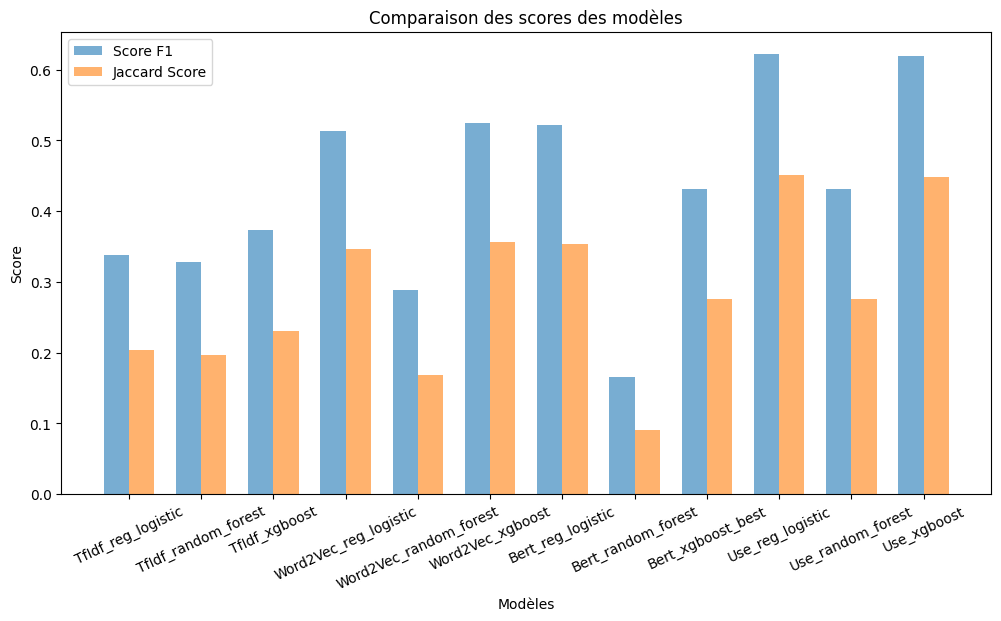

In [99]:
# Créer une liste d'indices pour chaque modèle
model_indices = np.arange(len(df_results['Model']))

# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(12, 6))

# Largeur des barres
bar_width = 0.35

# Tracer les résultats
f1_bars = ax.bar(model_indices - bar_width/2, df_results['F1_score'], bar_width, label='Score F1', alpha=0.6)
jaccard_bars = ax.bar(model_indices + bar_width/2, df_results['Jaccard_score'], bar_width, label='Jaccard Score', alpha=0.6)

# Ajoutez des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel('Score')
ax.set_title('Comparaison des scores des modèles')
ax.set_xticks(model_indices)
ax.set_xticklabels(df_results['Model'], rotation=25)
ax.legend()
plt.show()


### 8.2 Comparaison des pourcentages de prédictions <a class="anchor" id="8_22"></a>

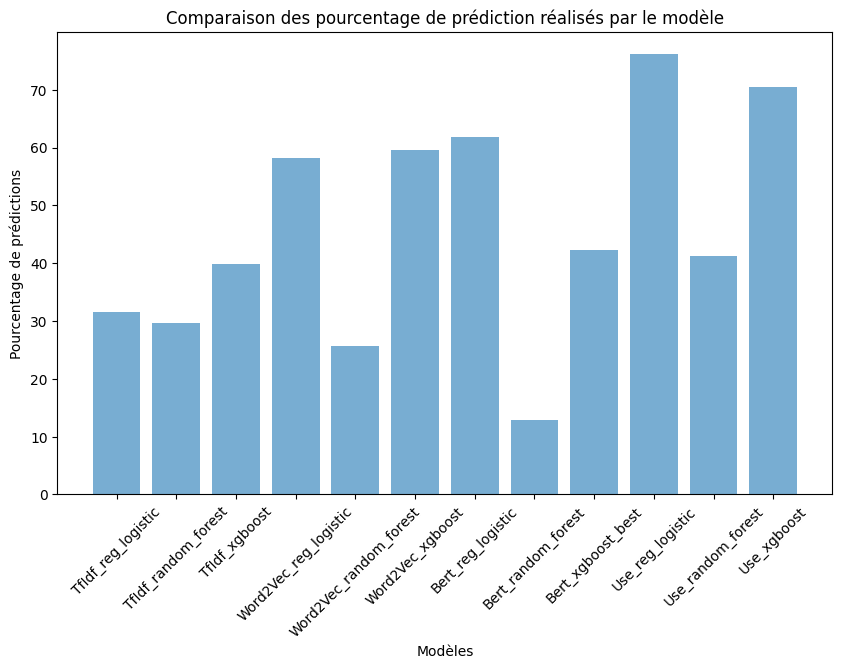

In [100]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_results['Model'], df_results["Taux de prédiction sur Test_set"], label='Pourcentage de prédictions', alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel("Pourcentage de prédictions")
ax.set_title("Comparaison des pourcentage de prédiction réalisés par le modèle")

# Afficher le graphique
plt.xticks(rotation=45)
plt.show()

### 8.3 Comparaison du temps d'exécution <a class="anchor" id="8_3"></a>

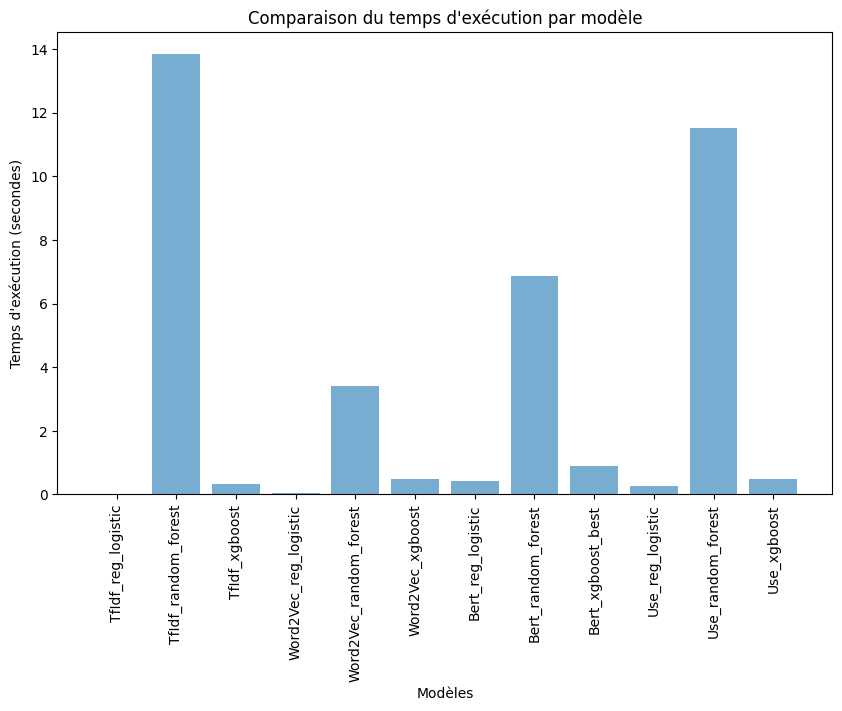

In [109]:
# Créer une figure et un axe pour les graphiques
fig, ax = plt.subplots(figsize=(10, 6))

# Tracer le temps d'exécution pour chaque modèle
ax.bar(df_results['Model'], df_results["Temps d'exécution du modèle"], label="Temps d'exécution", alpha=0.6)

# Ajouter des étiquettes et une légende
ax.set_xlabel('Modèles')
ax.set_ylabel("Temps d'exécution (secondes)")
ax.set_title("Comparaison du temps d'exécution par modèle")

# Afficher le graphique
plt.xticks(rotation=90)
plt.show()

## 9. Model Registry <a class="anchor" id="9"></a>

In [102]:
from mlflow.tracking import MlflowClient
tracking_URI = ngrok_tunel.public_url
tracking_URI

'https://8275-2a01-e0a-b69-82d0-1832-7d3d-9a03-e0db.ngrok-free.app'

### 9.1 Interraction avec le serveur MLflow Tracking pour extraire le run id avec les meilleur performances <a class="anchor" id="9_1"></a>

In [103]:
# Tracking_URI
client = MlflowClient(tracking_uri=tracking_URI)

# Liste des expériences
client.search_experiments()

[<Experiment: artifact_location='file:///C:\\Users\\Basti/mlruns/416587785806061639', creation_time=1706916647078, experiment_id='416587785806061639', last_update_time=1706916647078, lifecycle_stage='active', name='Tags_predict', tags={}>,
 <Experiment: artifact_location='file://C:\\Users\\Basti/mlruns/0', creation_time=1705310055511, experiment_id='0', last_update_time=1705310055511, lifecycle_stage='active', name='Default', tags={}>]

In [110]:
from mlflow.entities import ViewType

runs = client.search_runs(experiment_ids='416587785806061639',
                          filter_string='metrics.jaccard_score > 0.4',
                          run_view_type=ViewType.ACTIVE_ONLY,
                          max_results=5,
                          order_by=['metrics.jaccard_score DESC'])

In [111]:
for run in runs:
    print(f"run id: {run.info.run_id}, jaccard_score: {run.data.metrics['jaccard_score']:.4f}")

run id: 7a78469f39b347b59f0bd1abc617b42d, jaccard_score: 0.4515
run id: bc1b8b312fc24f979c78daf0a627099a, jaccard_score: 0.4483


### 9.2 Interraction avec le Model Registry <a class="anchor" id="9_2"></a>

In [118]:
mlflow.set_tracking_uri(tracking_URI)

run_id = '7a78469f39b347b59f0bd1abc617b42d'
model_uri = f"runs:/{run_id}/model"
mlflow.register_model(model_uri=model_uri, name='final_model')

Successfully registered model 'final_model'.
Created version '1' of model 'final_model'.


<ModelVersion: aliases=[], creation_timestamp=1707203959864, current_stage='None', description='', last_updated_timestamp=1707203959864, name='final_model', run_id='7a78469f39b347b59f0bd1abc617b42d', run_link='', source='file:///C:\\Users\\Basti/mlruns/416587785806061639/7a78469f39b347b59f0bd1abc617b42d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [119]:
model_name = 'final_model'
lastest_versions = client.get_latest_versions(name=model_name)

for version in lastest_versions:
    print(f'version: {version.version}, stage: {version.current_stage}')

C:\Users\Basti\AppData\Local\Temp\ipykernel_8752\259214655.py:2: FutureWarning: ``mlflow.tracking.client.MlflowClient.get_latest_versions`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.0/model-registry.html#migrating-from-stages
  lastest_versions = client.get_latest_versions(name=model_name)


version: 1, stage: None


In [120]:
model_version = 1
new_stage = 'Production'
client.transition_model_version_stage(name=model_name,
                                     version=model_version,
                                     stage=new_stage,
                                     archive_existing_versions=False)

C:\Users\Basti\AppData\Local\Temp\ipykernel_8752\58218801.py:3: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.10.0/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(name=model_name,


<ModelVersion: aliases=[], creation_timestamp=1707203959864, current_stage='Production', description='', last_updated_timestamp=1707204000223, name='final_model', run_id='7a78469f39b347b59f0bd1abc617b42d', run_link='', source='file:///C:\\Users\\Basti/mlruns/416587785806061639/7a78469f39b347b59f0bd1abc617b42d/artifacts/model', status='READY', status_message='', tags={}, user_id='', version='1'>

In [256]:
# Enregistrer le modèle en .pkl (pour API en local)
final_model = mlflow.pyfunc.load_model(
    r"C:\Users\Basti\mlruns\416587785806061639\7a78469f39b347b59f0bd1abc617b42d\artifacts\log_reg")

with open("final_model.pkl", "wb") as file:
    pickle.dump(final_model, file)

## 10. Prédictions des modèles sur la base entière <a class="anchor" id="10"></a>

In [250]:
# Enregistrer du modèle tfidf (il nous servira pour une démonstration de déploiement continu)
model_tfidf = mlflow.pyfunc.load_model(
    r"C:\Users\Basti\mlruns\416587785806061639\83e72bbaf2df4eed83aa0b43abf4478a\artifacts\log_reg")

In [251]:
# Enregistrer les prédictions des modèles
predict_tfidf = model_tfidf.predict(X_tfidf)
predict_use = final_model.predict(X_use)

In [252]:
# Rajout des prédictions dans la copie de df
df_prediction = df.copy()
df_prediction['tfidf_pred'] = multilabel_binarizer.inverse_transform(predict_tfidf)
df_prediction['use_pred'] = multilabel_binarizer.inverse_transform(predict_use)

In [253]:
# Affichage
df_prediction

,Id,clean_title_body,clean_tags,tfidf_pred,use_pred
0,45026159,"['data', 'binding', 'adapter', 'android', 'pop...",['android'],"(android,)","(android,)"
1,45036635,"['thread', 'starvation', 'performance', 'testi...","['.net', 'c#']",(),"(java,)"
2,45037328,"['http', 'proxy', 'completely', 'ssl', 'connec...",['python'],"(python,)",()
3,45037335,"['chart', 'chart', 'color', 'border', 'line', ...","['javascript', 'react']","(python,)","(python,)"
4,45037547,"['logarithm', 'rust', 'java', 'rust', 'per', '...",['java'],"(java,)","(java,)"
...,...,...,...,...,...
40396,77544923,"['aggregate', 'column', 'list', 'intersection'...",['python'],(),"(python,)"
40397,77551316,"['char', 'literal', 'persistently', 'exist', '...",['c++'],(),"(c++,)"
40398,77556444,"['null', 'primary', 'constructor', 'c#', 'c#',...","['.net', 'c#']",(),"(.net, c#)"
40399,77564335,"['loading', 'external', 'script', 'facing', 's...","['google', 'javascript']","(javascript,)","(javascript,)"


In [257]:
# Enregistrement en csv
df_prediction.to_csv('Predictions_modeles_API.csv')

## 11. Enregistrement des .pkl pour l'API <a class="anchor" id="11"></a>

In [255]:
# Enregistrement du MultilabelBinarizer
with open('multilabel_binarizer.pkl', 'wb') as binarizer_file:
    pickle.dump(multilabel_binarizer, binarizer_file)
    
# Enregistrement du modèle en .pkl pour le modèle de régression logistique avec TF-IDF pour démo API online
with open("API_online_model.pkl", "wb") as file:
    pickle.dump(model_tfidf, file)
    
# Entrainement du TF-IDF sur la matrice X pour enregistrement
tfidf = tfidf_vectorizer.fit(X)
    
# Enregistrement du modèle TF-IDF en .pkl por démo API online
with open('tfidf_model.pkl', 'wb') as file:
    pickle.dump(tfidf, file)